In [1]:
from IPython.display import clear_output
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
labelsize = 16

from scipy.optimize import minimize
from func.propagation import defmodel, extend_model
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

precision = np.float32
device = 'cpu'

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v

def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec = np.unique(zxrec,axis=1)

  return zxrec

In [2]:
def prop2d_cpu(pwsrc,vel,at,az,ax,next):
	"""
	2d wave propagation
	Resolution with finite differences
	Orders 2 in time and space
	with absorbing boundaries (Clayton and Engquist)
	Vectorial implementation (much faster)
	"""
	nabs  = 10
	next2 = nabs + next
	nt    = len(at)
	nz    = len(az)
	nx    = len(ax)
	dz    = az[1] - az[0]
	dx    = ax[1] - ax[0]
	dt    = at[1] - at[0]   
	dz2   = 1./dz**2
	dx2   = 1./dx**2
	# Extend the model
	nze  = nz + 2*next2
	nxe  = nx + 2*next2
	vele = extend_model(vel,next2)
	# Shift the source by next
	p     = np.zeros([nze,nxe,nt], dtype=precision)
	pm    = np.zeros([nze,nxe], dtype=precision) # Previous wave field

	fact = (dt*vele[1+nabs:-1-nabs,1+nabs:-1-nabs])**2	

	for it in range(1,nt-1): # From 1 to nt-1
		# sys.stdout.write(".")
		# sys.stdout.flush()
		# Second-order derivatives in z and x
		# + source term
		pt   = p[:,:,it]
		lapx = (pt[1+nabs:-1-nabs,0+nabs:-2-nabs] - \
				2.*pt[1+nabs:-1-nabs,1+nabs:-1-nabs] + \
				pt[1+nabs:-1-nabs,2+nabs:-nabs])*dz2
		lapz = (pt[0+nabs:-2-nabs,1+nabs:-1-nabs] - \
				2.*pt[1+nabs:-1-nabs,1+nabs:-1-nabs] + \
				pt[2+nabs:-nabs,1+nabs:-1-nabs])*dx2
		asrc = np.zeros([nze-2*nabs-2,nxe-2*nabs-2])
		asrc[next:-next,next:-next] = pwsrc[1:-1,1:-1,it]
		pp = \
			2.*pt[1+nabs:-1-nabs,1+nabs:-1-nabs] - \
			pm[1+nabs:-1-nabs,1+nabs:-1-nabs] + \
			(lapz + lapx + asrc)*fact
		p[1+nabs:-1-nabs,1+nabs:-1-nabs,it+1] = pp
		pm = pt
	
	return p[next2:nze-next2,next2:nxe-next2,:]


def prop2d(wsrc, zxsrc, vel, at, az, ax, next, device):
	"""
	2d wave propagation with multiple sources
	"""
	if wsrc.ndim == 1: wsrc=np.array([wsrc]) # convert source wavelet from 1d to 2d
	zxsrc = np.array(zxsrc)
	nz, nx, nt = len(az),len(ax),len(at)
	pwsrc = np.zeros([nz, nx, nt]) # creat a initial p with zeros
	pwsrc[zxsrc[0,:], zxsrc[1,:], :wsrc.shape[1]] = wsrc # insert source wavelet
	# if device=='gpu': p = prop2d_gpu(pwsrc, vel, at, az, ax, next) # propagate
	if device=='cpu': p = prop2d_cpu(pwsrc, vel, at, az, ax, next) # propagate

	return p

Min velocity: 2006.27  Max velocity 2998.51
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 800


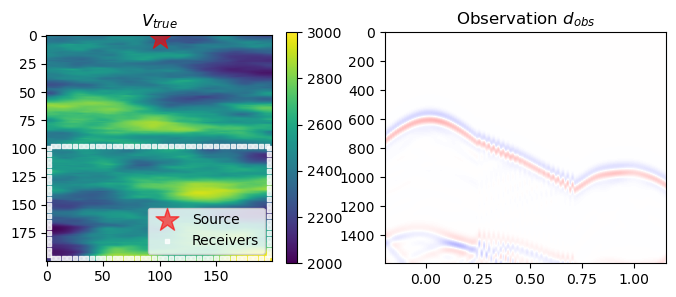

In [95]:
# Model size (nz,nx) = (200,200)

import pickle
# load data
filename = './data/u_200'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_200'
infile = open(filename, 'rb')
Q = pickle.load(infile).astype('float32')
Q.astype('float32')
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,800
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
nrec = len(receivers_width)
zxrec = receiver_position(3)

p = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)
d_obs = p[zxrec[0], zxrec[1], :]

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

## Reference code (Transformed)

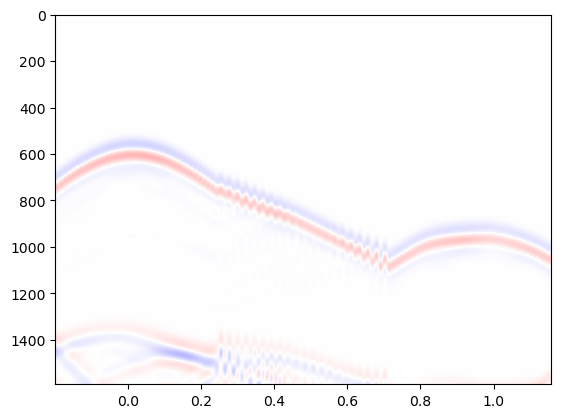

In [171]:
import numpy as np
import scipy.sparse as sp

vel = v_ref.reshape((nz,nx))
pwsrc = np.zeros([nz, nx, nt]) # creat a initial p with zeros
pwsrc[zxsrc[0,:], zxsrc[1,:], :wsrc.shape[0]] = wsrc # insert source wavelet
next = 100
"""
2d wave propagation
Resolution with finite differences
Orders 2 in time and space
with absorbing boundaries (Clayton and Engquist)
Vectorial implementation (much faster)
"""
nabs  = 10
next2 = nabs + next
nt    = len(at)
nz    = len(az)
nx    = len(ax)
dz    = az[1] - az[0]
dx    = ax[1] - ax[0]
dt    = at[1] - at[0]   
_dz2   = 1./dz**2
_dx2   = 1./dx**2

# Extend the model
nze  = nz + 2*next2
nxe  = nx + 2*next2
vele = extend_model(vel,next2)

# Shift the source by next
asrc = np.zeros([nze-2*nabs-2,nxe-2*nabs-2])
p     = np.zeros([nze,nxe,nt], dtype=precision)
pm    = np.zeros([nze,nxe], dtype=precision) # Previous wave field
fact = (dt * vele[nabs:-nabs,nabs:-nabs])**2

# Construct the sparse Laplacian matrix
nze = nz + 2 * next2
nxe = nx + 2 * next2

# Calculate the size of the Laplacian matrix
nzz, nxx = nz + 2*next, nx + 2*next
size = nzz * nxx

# Construct the Laplacian matrix
# diagonal = fact.flatten() * (-2*np.ones(size)*(_dz2+_dx2)) + 2*np.ones(size)
diagonal = -2*np.ones(size)*(_dz2+_dx2)
off_diagonal_x = np.ones(size - 1) * _dz2
off_diagonal_z = np.ones(size - nxx) * _dx2

# Set the off-diagonal elements of the Laplacian matrix for the x- and z-direction neighbors
off_diagonal_x[nxx - 1::nxx] = 0
off_diagonal_z[-nxx:] = 0

# Create the Laplacian matrix using the diagonal and off-diagonal values
L = sp.diags([off_diagonal_x, off_diagonal_z, diagonal, off_diagonal_z, off_diagonal_x],
             [-1, -nxx, 0, nxx, 1], shape=(size, size))
T = sp.diags(fact.flatten(), 0, format='csr').dot(L) + sp.diags(2*np.ones(size), 0, format='csr')

for it in range(1,nt-1): # From 1 to nt-1
        pt   = p[:,:,it]
        pt_T = T.dot(pt[nabs:-nabs, nabs:-nabs].flatten()).reshape(nzz, nxx)[1:-1, 1:-1]
        # Update the sourse term at current epoch
        asrc[next:-next,next:-next] = pwsrc[1:-1,1:-1,it]
        # Update pp = T * pt - pm + asrc*fact
        p[1+nabs:-1-nabs,1+nabs:-1-nabs,it+1] = \
                pt_T - pm[1+nabs:-1-nabs,1+nabs:-1-nabs] + asrc*fact[1:-1, 1:-1]
        pm = pt

p = p[next2:nze-next2,next2:nxe-next2,:]
d_obs = p[zxrec[0], zxrec[1],:]
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')

## Test code I

In [187]:
import numpy as np
import scipy.sparse as sp

vel = v_ref.reshape((nz,nx))
pwsrc = np.zeros([nz, nx, nt]) # creat a initial p with zeros
pwsrc[zxsrc[0,:], zxsrc[1,:], :wsrc.shape[0]] = wsrc # insert source wavelet
next = 100
"""
2d wave propagation
Resolution with finite differences
Orders 2 in time and space
with absorbing boundaries (Clayton and Engquist)
Vectorial implementation (much faster)
"""
nabs  = 10
next2 = nabs + next
nt    = len(at)
nz    = len(az)
nx    = len(ax)
dz    = az[1] - az[0]
dx    = ax[1] - ax[0]
dt    = at[1] - at[0]   
_dz2   = 1./dz**2
_dx2   = 1./dx**2

# Extend the model
nze  = nz + 2*next2
nxe  = nx + 2*next2
vele = extend_model(vel,next2)

# Shift the source by next
asrc = np.zeros([nze-2*nabs-2,nxe-2*nabs-2])
p     = np.zeros([nze,nxe,nt], dtype=precision)
pm    = np.zeros([nze,nxe], dtype=precision) # Previous wave field
fact = (dt * vele[nabs-1:-nabs+1,nabs-1:-nabs+1])**2

# Construct the sparse Laplacian matrix
nze = nz + 2 * next2
nxe = nx + 2 * next2

# Calculate the size of the Laplacian matrix
nzz, nxx = nz + 2*next + 2, nx + 2*next + 2
size = nzz * nxx

# Construct the Laplacian matrix
# diagonal = fact.flatten() * (-2*np.ones(size)*(_dz2+_dx2)) + 2*np.ones(size)
diagonal = -2*np.ones(size)*(_dz2+_dx2)
off_diagonal_x = np.ones(size - 1) * _dz2
off_diagonal_z = np.ones(size - nxx) * _dx2

# Set the off-diagonal elements of the Laplacian matrix for the x- and z-direction neighbors
off_diagonal_x[nxx - 1::nxx] = 0
off_diagonal_z[-nxx:] = 0

# Create the Laplacian matrix using the diagonal and off-diagonal values
L = sp.diags([off_diagonal_x, off_diagonal_z, diagonal, off_diagonal_z, off_diagonal_x],
             [-1, -nxx, 0, nxx, 1], shape=(size, size))
T = sp.diags(fact.flatten(), 0, format='csr').dot(L) + \
        sp.diags(2*np.ones(size), 0, format='csr')

mask = np.zeros((nzz, nxx), dtype=bool)
mask[1:-1, 1:-1] = True
mask = mask.flatten()

for it in range(1,nt-1): # From 1 to nt-1
        pt   = p[:,:,it]
        pt_T = T.dot(np.pad(pt[nabs:-nabs, nabs:-nabs],1).flatten())[mask].reshape(nze-2*nabs,nxe-2*nabs)
        # Update the sourse term at current epoch
        asrc[next:-next,next:-next] = pwsrc[1:-1,1:-1,it]
        # Update pp = T * pt - pm + asrc*fact
        p[nabs:-nabs,nabs:-nabs,it+1] = \
                pt_T - pm[nabs:-nabs,nabs:-nabs] + asrc*fact
        pm = pt

p = p[next2:nze-next2,next2:nxe-next2,:]
d_obs = p[zxrec[0], zxrec[1],:]
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')

ValueError: operands could not be broadcast together with shapes (398,398) (402,402) 